# SYDE556/750 Assignment 3: Connecting Neurons

- Due Date: March 6rd
- Total marks: 10 (10% of final grade)
- Late penalty: 1 mark per day

- It is recommended that you use a language with a matrix library and graphing capabilities.  Two main suggestions are Python and MATLAB.
- *Do not use any code from Nengo*

In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
def getRMS(sig):
    return np.sqrt(1/float(len(sig)) * np.sum(np.power(sig,2)))

def calcAlpha(tau_ref, tau_rc, maxFR, xint, xmax = None):
    if not(xmax):
        xmax = 1
    a = (1/float(xint+xmax))
    b = 1/(1-np.exp((1/tau_rc) * (tau_ref-1/float(maxFR))))
    return  a * b

def LIFcurve(tau_ref, tau_rc, J):
    A = np.zeros(J.shape)
    for x,j in enumerate(J):
        A[x] = (tau_ref - (tau_rc*np.log(1-j**(-1))))**(-1) if (j > 1) else 0
    return A

def generate_signal(T, dt, rms, limit, seed=None):
    if (seed):
        np.random.seed(seed)
    Len = T/dt
    
    t = np.linspace(0, T, int(T/dt))
    sig = np.random.normal(0,1, t.shape)                   # generate a random normal time domain signal (white noise)
    w_pos = np.linspace(0,np.int(1/(2*dt)), int(T/(2*dt)+1))
    
    SIG = fft.rfft(sig)
    FILT = np.piecewise(w_pos, [w_pos <= limit, w_pos > limit], [lambda w_pos: 1, lambda w_pos: 0]) # Create a box filter
    FILT[0] = 0        # DC = 0
    SIG2 = SIG*FILT    # Apply the box filter
    
    sig2 = fft.irfft(SIG2)
    sig2 = sig2 * rms/getRMS(sig2)
    SIG2 = fft.rfft(sig2)          # recalculate fft after scaling
    
    return sig2, abs(SIG2)

In [3]:
class SingleNeuron():
    T = 0
    dt = 0.001
    
    x = np.linspace(0,1, int(1/dt))
    time = np.linspace(0,1, int(1/dt))
    encoder = 1
    maxFR = 0
    xint = 0
    alpha = 0
    jbias = 0
    J = 0
    a = 0
    V = 0
    dV = 0
    tau_rc = 0
    tau_ref = 0
    spikes = 0
    
    def __init__(self, T, dt, tau_rc, tau_ref, encoder = None, seed = None, maxFR = None, xlim = None):
       
    # initialize some variables
        if encoder:
            self.encoder = encoder
        else:
            rand = np.random.randint(low = 1, high = 10)
            self.encoder = (-1)**rand
    # randomly set the firing rate and xint
        if maxFR:
            self.maxFR = maxFR
        else:
            self.maxFR = np.random.uniform(low = 100, high = 200)
        if not(xlim):
            xlim = 1
        self.xint = np.random.uniform(low = -2, high = 2)
        
        self.T = T
        self.dt = dt
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.x = np.linspace(-xlim, xlim, int(2*xlim/dt))
        self.time = np.linspace(0, T, int(T/dt))
        
        if seed:
            np.random.seed(seed)     
        
    # calculate jbias and alpha
        self.alpha = calcAlpha(self.tau_ref, self.tau_rc, self.maxFR, self.xint, xmax = 2)
        self.jbias = self.alpha * self.xint
        
        self.J = self.getJ(self.x)                        # Calculate the current as a funtion of input x
        self.a = LIFcurve(tau_ref, tau_rc, self.J)        # Calculate the firing rate as a function of current
        
    def getJ(self, x):
        J = np.dot(self.encoder, self.alpha * x) + self.jbias
        J[J < 0] = 0
        return J
        
    def spikeTrain(self, x):
        n = np.int(self.T/self.dt)          # number of samples
        if isinstance(x, int):
            j = np.full([n], self.getJ(x))  # if our input signal is constant
        else:
            j = self.getJ(x)                # if input is a function of time
        
    # initialize our Spikes, Voltage and dV functions
        self.V = np.zeros([n])
        self.spikes = np.zeros([n])
        self.V[0] = 0
        self.dV = np.zeros([n])
    # Calculate dV and V for each time step
        for i in range(0,n):
            self.dV[i] = 2*pi/self.tau_rc * (j[i] - self.V[i]) * self.dt     # calculate dV given the previous V
            if i < len(self.V)-1:                                            # if we're not at the end
                self.V[i+1] = self.V[i] + self.dV[i]                         # calculate next V given dV and previous V
                if self.V[i+1] >= 1:                                         # if the next V will be over 1, we spike and set V to 0
                    self.V[i+1] = 0
                    self.spikes[i] = 1 
        return self.spikes
    def plot(self):
        plt.plot(self.x, self.a)

In [4]:
class NeuronPair():
    pos = 0
    neg = 0
    time = 0
    def __init__(self, T, dt, tau_rc, tau_ref, Neuron = None):
        # create the positive encoded single neuron
        if Neuron:
            self.pos = Neuron
        else:
            x = np.linspace(0,1, int(1/dt))
            self.pos = SingleNeuron(T = T, dt = dt, tau_rc = tau_rc, tau_ref = tau_ref, encoder = 1, xlim=2)

        # create the negative encoded single neuron
        self.neg = SingleNeuron(T, dt, tau_rc = tau_rc, tau_ref = tau_ref, xlim=2, encoder = -self.pos.encoder, maxFR = self.pos.maxFR)
        self.time = self.pos.time

    def spikeTrains(self, x):
        # return a 2xN matrix of spike trains 
        return [self.pos.spikeTrain(x), self.neg.spikeTrain(x)]

## 1) Decoding from a population

As you did in previous assignments, make a population of 20 LIF neurons representing a 1-dimensional value, and compute a decoder for them.  For parameters, $\tau_{ref}$=0.002s, $\tau_{RC}$=0.02s, the maximum firing rates are chosen randomly from a uniform distribution between 100 and 200Hz (at the max radius), and the x-intercepts are chosen randomly from a uniform distribution between -2 and 2.  Remember that the $\alpha$ and $J^{bias}$ terms are computed based on these x-intercepts and maximum firing rates.

It is generally easiest to compute decoders using the original method from Assignment 1, where we use the rate-mode approximation for the neurons to generate the $A$ matrix, then find $\Gamma=A^T A + \sigma^2 I$.  You can use this approach to find decoders, and these decoders should work even when you simulate the neurons in terms of spikes (in question 2 on).  The only difference will be that they will need to be scaled by ``dt``, your simulation time step.

You can use this same method for computing decoders for this whole assignment.

In [5]:
def calcDecoders(A, x, dt, noise=None, sigmaCoeff = None):
    Ypsilon = dt * np.dot(A,x)
    Gamma = dt * np.matmul(A, np.transpose(A))
    if noise:
        Var = np.power(sigmaCoeff * np.max(A),2) * np.identity(A.shape[0])
        Gamma += Var
    Gamma_inv = np.linalg.inv(Gamma)
    try:
        d = np.dot(Gamma_inv, Ypsilon) 
        d = np.transpose(np.matrix([d]))
    except:
        d = np.dot(Gamma_inv, np.transpose(Ypsilon))
    return d # vector of decoders

def addNoise(A, sigmaCoeff):
    Anoise = A + np.random.normal(loc = 0, scale = sigmaCoeff * np.max(A), size = A.shape)
    for i in range(0,A.shape[0]): #for each neuron
        for j in range(0, A.shape[1]): # for each step in x
            Anoise[i][j] = max(Anoise[i][j], 0)
    return Anoise

In [6]:
N = 20
dt = 0.001
T = 1
x = np.linspace(-2, 2, int(4/dt))
A = np.zeros([N,len(x)])
Neurons = [None] * N

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the tuning curves (firing rate of each neuron for different $x$ values between -2 and 2)</li>
</ol>

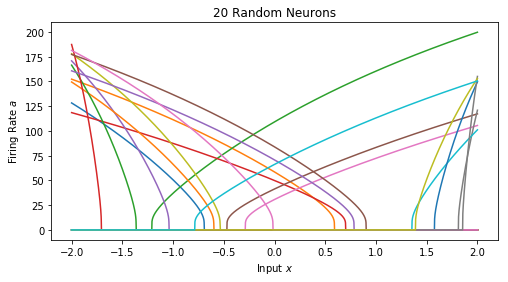

In [7]:
plt.figure(figsize(8,4))
plt.title("20 Random Neurons")
for n in range(0,N):
    neu = SingleNeuron(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = n, xlim = 2)
    Neurons[n] = neu
    A[n] = neu.a
    plt.plot(x, neu.a)
    plt.xlabel('Input $x$')
    plt.ylabel('Firing Rate $a$')

<ol style="list-style:lower-alpha outside none;" start="2">
<li> [0.5 marks] Compute the decoders and plot $(x-\hat{x})$.  When computing decoders, take into account noise ($\sigma$=0.1 times 200Hz).  When computing $\hat{x}$, add random gaussian noise with $\sigma$=0.1 times 200Hz to the activity. Report the Root Mean-Squared Error (RMSE).</li>
</ol>

RMS = 0.154532846617


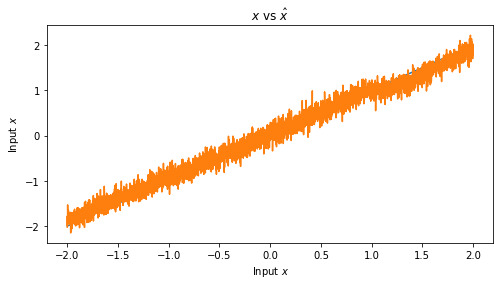

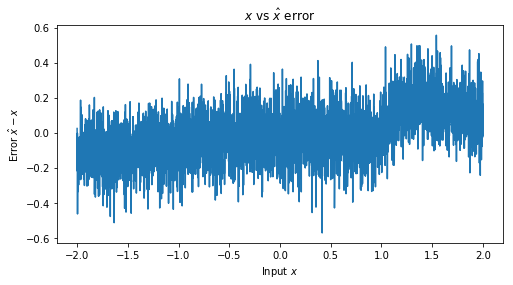

In [8]:
Anoise = addNoise(A, 0.1)
d = calcDecoders(A, x, dt, noise = True, sigmaCoeff = 0.1)

xhat = np.dot(np.transpose(Anoise), d)

plt.figure()
plt.title("$x$ vs $\hat x$")
plt.plot(x,x)
plt.plot(x, xhat)
plt.xlabel('Input $x$')
plt.ylabel('Input $x$');

diff = np.subtract(np.transpose(x), np.transpose(xhat))

plt.figure()
plt.title("$x$ vs $\hat x$ error ")
plt.plot(x, np.transpose(diff))
plt.xlabel('Input $x$')
plt.ylabel('Error $\hat x - x$');

RMS = getRMS(np.transpose(diff))
print "RMS = " + str(RMS)

## 2) Decoding from two spiking neurons

Choose a neuron from part 1 that has a firing rate of somewhere between 20-50Hz for $x$=0.  Using that neuron's $\alpha$ and $J^{bias}$ value, construct two neurons: both with the same $\alpha$ and $J^{bias}$, but one with $e$=+1 and the other with $e$=-1.  With the function from the last assignment, generate a random input $x(t)$ that is 1 second long, with rms=1, dt=0.001, and an upper limit of 5Hz.  Feed that signal into the two neurons and generate spikes.  Decode the spikes back into $\hat{x}(t)$ using a post-synaptic current filter $h(t)$ with a time constant of $\tau$=0.005.

In [9]:
t = np.linspace(0, 1, int(1/dt))
x_input, X_INPUT = generate_signal(T = 1, dt = 0.001, rms = 1, limit = 5, seed = 2)
    
myNeuron = SingleNeuron(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, encoder = 1, maxFR = np.random.uniform(20,50))
myPair = NeuronPair(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, Neuron = myNeuron)

# returns the filtered spikes of a neuron in response to x_input
def postSynapticFilter(Neuron, x_input):
    spikes = Neuron.spikeTrain(x = x_input)
    SPIKES = fft.rfft(spikes)

    # Create the filter
    h = np.exp(-t/0.005)
    h = h / sum(h) 
    H = (fft.rfft(h))

    FSPIKES = H*SPIKES
    fspikes = fft.irfft(FSPIKES)
    
    return fspikes

# returns the reconstructed signal from post-synaptic current matrix
def decode(A2, x_input):
#     A2 = np.array(fspikes)
    d2 = calcDecoders(A2, x_input, dt = 0.001, noise = True, sigmaCoeff = 0.1)
    xhat2 = np.dot(np.transpose(A2), d2)
    return xhat2

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[0.5 marks] Plot the post-synaptic current $h(t)=e^{-t/\tau}/ \int e^{-t/\tau} dt$</li>
</ol>

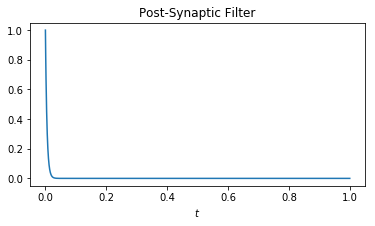

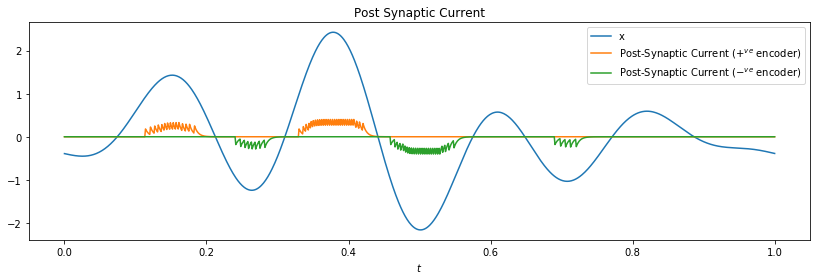

In [10]:
A2_p = np.array(postSynapticFilter(myPair.pos, x_input))
A2_n = np.array(postSynapticFilter(myPair.neg, x_input))
A2 = np.matrix([A2_p, A2_n])

plt.figure(figsize=(6,3))
plt.title("Post-Synaptic Filter")
plt.plot(t, np.exp(-t/0.005))
plt.xlabel("$t$")
plt.show();

plt.figure(figsize=(14,4))
plt.title("Post Synaptic Current")
plt.plot(t, x_input, label="x")
plt.plot(t, A2_p, label="Post-Synaptic Current ($+^{ve}$ encoder)")
plt.plot(t, -A2_n, label="Post-Synaptic Current ($-^{ve}$ encoder)")
plt.xlabel("$t$")
plt.legend(loc="best")
plt.show();

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph</li>
</ol>

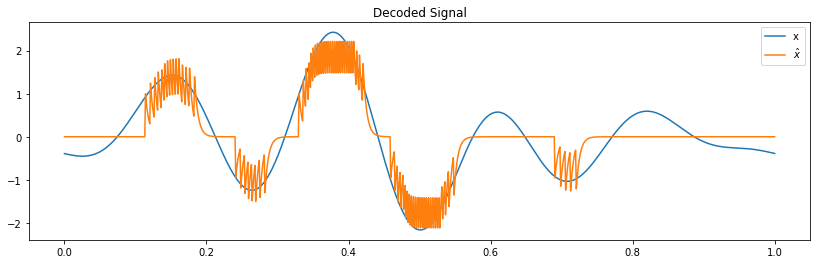

In [11]:
xhat2 = decode(A2, x_input)

plt.figure(figsize=(14,4))
plt.title("Decoded Signal")
plt.plot(t, x_input, label="x")
plt.plot(t, xhat2, label="$\hat x$")
plt.legend(loc="best")
plt.show();

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[0.5 marks] Compute the RMSE of the decoding</li>
</ol>

In [12]:
diff = np.transpose(x_input) - np.transpose(xhat2)
RMS2 = getRMS(diff)
print "RMSE = " + str(RMS2)

RMSE = 13.4534349456


## 3) Decoding from many neurons

Repeat question 2, but with more neurons.  Instead of picking particular neurons, randomly generate them with x-intercepts uniformly distributed between -2 and 2 and with maximum firing rates between 100 and 200 Hz.  Randomly choose encoder values to be either -1 or +1.

In [13]:
dt = 0.001
t = np.linspace(0, 1, int(1/dt))

def randomPopulationRMS(N, i):
    x_input3, X_INPUT3 = generate_signal(T = 1, dt = dt, rms = 1, limit = 5, seed = i)
    A3 = np.zeros([N,int(1/dt)])
    Neurons3 = [None] * N

#     plt.figure(figsize(14,4))
#     plt.plot(t, x_input3, label="$x$")
    for n in range(0,N):
        neu = SingleNeuron(T = 1, dt = 0.001, tau_rc = 0.02, tau_ref = 0.002, seed = i*n)
        Neurons3[n] = neu
        fspike = postSynapticFilter(neu, x_input3)
        A3[n] = np.array(fspike)
#         plt.plot(t, neu.encoder * A3[n])
#     plt.legend(loc="best")
#     plt.show();

    xhat3 = decode(A3, x_input3)

#     plt.figure(figsize(14,4))
#     plt.plot(t, x_input3, label="$x$")
#     plt.plot(t, xhat3, label="$\hat x$")
#     plt.legend(loc="best")
#     plt.show();

    diff = np.transpose(x_input3) - np.transpose(xhat3)
    return getRMS(diff)

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[2 marks] Plot Root Mean-Squared Error as the number of neurons increases, on a log plot.  Try 8 neurons, 16 neurons, 32, 64, 128, up to 256.  For the RMSE for a particular number of neurons, average over at least 5 randomly generated groups of neurons.  For each group of neurons, randomly generate the signal $x(t)$.  Use the same parameters as in question 2. Note: the RMSE should go down as the number of neurons increases</li>
</ol>

In [14]:
popSizes = [8, 16, 32, 64, 128, 256]
samples = 5
avgRMS = np.zeros(len(popSizes))

for n,N in enumerate(popSizes):
    rms = np.zeros(samples)
    for i in range(1,samples):
        rms[i] = randomPopulationRMS(N, i)
    avgRMS[n] = np.mean(rms)
    print "Population Size: " + str(N) + ", avgRMS: "  + str(avgRMS[n])

Population Size: 8, avgRMS: 4.4891035086
Population Size: 16, avgRMS: 3.56138492045
Population Size: 32, avgRMS: 2.86565426821
Population Size: 64, avgRMS: 2.61693564813
Population Size: 128, avgRMS: 2.52280756659
Population Size: 256, avgRMS: 2.45414611752


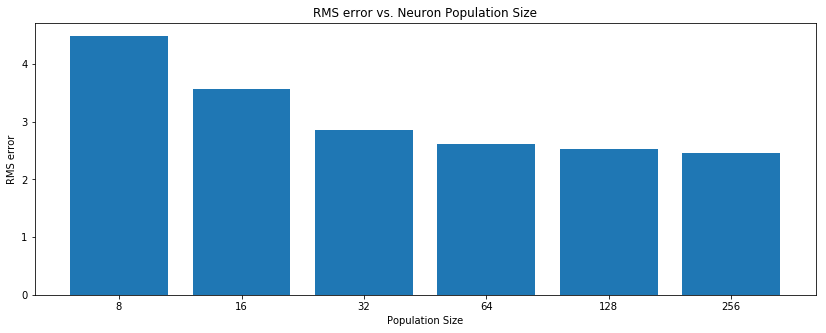

In [15]:
plt.figure(figsize(14,5))
plt.bar(np.log2(popSizes), avgRMS, tick_label=popSizes)
plt.title("RMS error vs. Neuron Population Size")
plt.xlabel("Population Size")
plt.ylabel("RMS error")
plt.show();

## 4) Connecting two groups of neurons

For this question, use two groups of neurons with intercepts between [-1, 1] to compute $y = 2x+1$.  The first group of neurons will represent $x$ and the second group will represent $y$.

Start by computing decoders.  You will need two decoders: one to decode $f(x)=2x+1$ from the first population, and one to decode $f(y)=y$ (the standard representational decoder) from the second population.  Remember that $\Upsilon$ can change depending on what function you want to decode.

Use the same neuron parameters as for previous questions, and use 200 randomly generated neurons in each population.

In [16]:
def calcDecoders4(A, x, dt, noise = None, sigmaCoeff = None, fn = None):
    if not(fn):
        def fn(a):
            return a
    Ypsilon = dt * np.dot(A, fn(x))
    Gamma = dt * np.matmul(A, np.transpose(A))
    if noise:
        Var = np.power(sigmaCoeff * np.max(A),2) * np.identity(A.shape[0])
        Gamma += Var
    Gamma_inv = np.linalg.pinv(Gamma)
    try:
        d = np.dot(Gamma_inv, Ypsilon) 
#         d = np.transpose(np.matrix([d]))
    except e:
        d = np.dot(Gamma_inv, np.transpose(Ypsilon))
    return d # vector of decoders

In [17]:
def function(x):
    return 2*x + 1

N = 20
dt = 0.001
T = 1
t4 = np.linspace(0,1, int(1/dt))
x4 = t4 - 1
A4x = np.zeros([N,len(x4)])
A4y = np.zeros([N,len(x4)])
Neurons4x = [None] * N
Neurons4y = [None] * N

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Show the behaviour of the system with an input of $x(t)=t-1$ for 1 second (a linear ramp from -1 to 0).  Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.</li>
<ul>
<li>Note that you should use the decoders that work for any input over the range of intercepts: do not re-compute decoders for any particular input (i.e. set of $x$ values).</li>
<li>Input $x(t)$ into the first group of neurons and produce spikes.  Decode from those spikes using the decoder for $f(x)=2x+1$.  Input that decoded result into the second group of neurons to produce spikes.  Use the second decoder ($f(y)=y$) to decode $\hat{y}(t)$.</li>
</ul>

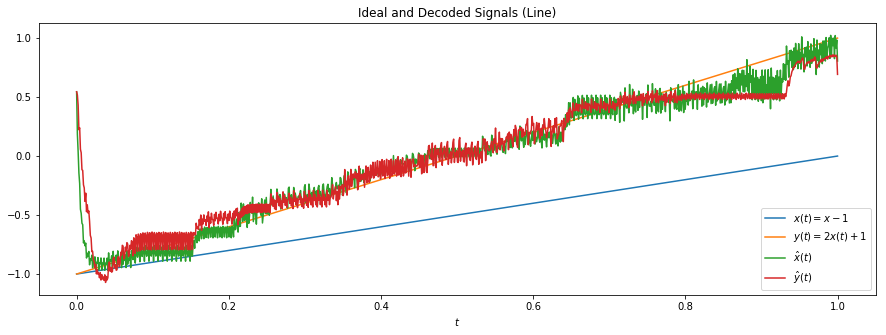

In [18]:
for n in range(0,N):
    Neurons4x[n] = SingleNeuron(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = n)
    A4x[n] = postSynapticFilter(Neurons4x[n], x4)
    
d4x = calcDecoders4(A4x, x4, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = function)
xhat4 = np.dot(np.transpose(A4x), d4x)

for n in range(0,N):
    Neurons4y[n] = SingleNeuron(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = N+n)
    A4y[n] = postSynapticFilter(Neurons4y[n], xhat4)

d4y = calcDecoders4(A4y, xhat4, dt = 0.001, noise = True, sigmaCoeff = 0.1)
yhat4 = np.dot(np.transpose(A4y), d4y)

plt.figure(figsize(15,5))
plt.title("Ideal and Decoded Signals (Line)")
plt.plot(t4, x4, label="$x(t) = x - 1$")
plt.plot(t4, function(x4), label="$y(t) = 2x(t) + 1$")
plt.plot(t4, xhat4, label="$\hat x(t)$")
plt.plot(t4, yhat4, label="$\hat y(t)$")
plt.xlabel("$t$")
plt.legend(loc="best")
plt.show();

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)</li>
</ol>

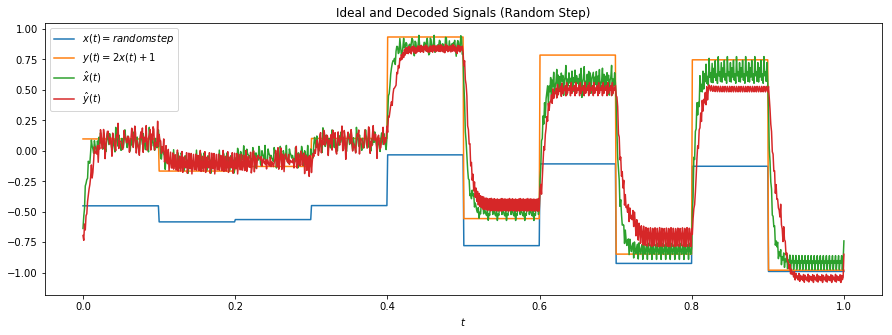

In [19]:
L = int(1/dt)

def randomStep():
    x4b = numpy.zeros(L)
    for i in range(10):
        np.random.seed(i)
        x4b[i*L/10:(i+1)*L/10]=numpy.random.uniform(-1,0)
    return x4b

x4b = randomStep()
A4bx = np.zeros([N,len(x4b)])
A4by = np.zeros([N,len(x4b)])

for n in range(0,N):
    A4bx[n] = postSynapticFilter(Neurons4x[n], x4b)
    
# d4bx = calcDecoders4(A4x, x4b, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = function)
xhat4b = np.dot(np.transpose(A4bx), d4x)

for n in range(0,N):
    A4by[n] = postSynapticFilter(Neurons4y[n], xhat4b)
# d4by = calcDecoders4(A4y, xhat4b, dt = 0.001, noise = True, sigmaCoeff = 0.1)
yhat4b = np.dot(np.transpose(A4by), d4y)

plt.figure(figsize(15,5))
plt.title("Ideal and Decoded Signals (Random Step)")
plt.plot(t4, x4b, label="$x(t) = random step$")
plt.plot(t4, function(x4b), label="$y(t) = 2x(t) + 1$")
plt.plot(t4, xhat4b, label="$\hat x(t)$")
plt.plot(t4, yhat4b, label="$\hat y(t)$")
plt.xlabel("$t$")
plt.legend(loc="best")
plt.show();

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[0.5 marks] Repeat part (a) with an input that is $x(t)=0.2sin(6\pi t)$. Briefly discuss the results for this question.</li>
</ol>

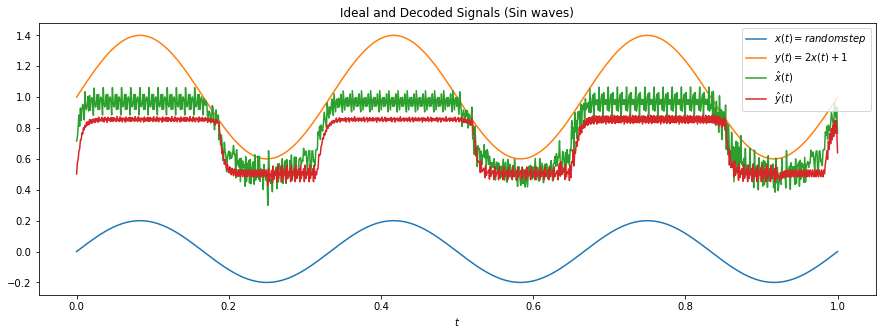

In [20]:
x4c = 0.2 * np.sin(6*np.pi*t4)
A4cx = np.zeros([N,len(x4c)])
A4cy = np.zeros([N,len(x4c)])

for n in range(0,N):
    A4cx[n] = postSynapticFilter(Neurons4x[n], x4c)
    
# d4bx = calcDecoders4(A4x, x4b, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = function)
xhat4c = np.dot(np.transpose(A4cx), d4x)

for n in range(0,N):
    A4cy[n] = postSynapticFilter(Neurons4y[n], xhat4c)
# d4by = calcDecoders4(A4y, xhat4b, dt = 0.001, noise = True, sigmaCoeff = 0.1)
yhat4c = np.dot(np.transpose(A4cy), d4y)

plt.figure(figsize(15,5))
plt.title("Ideal and Decoded Signals (Sin waves)")
plt.plot(t4, x4c, label="$x(t) = random step$")
plt.plot(t4, function(x4c), label="$y(t) = 2x(t) + 1$")
plt.plot(t4, xhat4c, label="$\hat x(t)$")
plt.plot(t4, yhat4c, label="$\hat y(t)$")
plt.xlabel("$t$")
plt.legend(loc="best")
plt.show();

> Since the Neurons saturate at +/- 1, a population of neurons cannot effectively track a signal that exceeds +/- 1. This population does just this, saturationg at 1, and tracking farily elsewhere.

## 5) Connecting three groups of neurons

For this question, use three groups of neurons with intercepts from [-1, 1] to compute $z = 2y+0.5x$.  Follow the same steps as question 4, but take the decoded outputs from the first two groups of neurons ($f(y)=2y$ and $f(x)=0.5x$), add them together, and feed that into the third group of neurons.

In [21]:
def fx(x):
    return 0.5*x
def fy(y):
    return 2*y

N = 20
dt = 0.001
T = 1
t5 = np.linspace(0,1, int(1/dt))
A5x = np.zeros([N,len(t5)])
A5y = np.zeros([N,len(t5)])
A5z = np.zeros([N,len(t5)])
Neurons5x = [None] * N
Neurons5y = [None] * N
Neurons5z = [None] * N

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=cos(3\pi t)$ and $y(t)=0.5 sin (2 \pi t)$ (over 1.0 seconds)</li>
</ol>

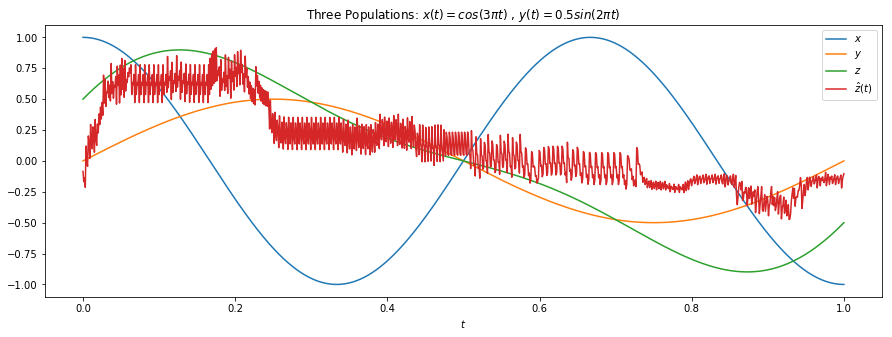

In [22]:
x5a = np.cos(3*np.pi * t5)
y5a = 0.5*np.sin(2*np.pi * t5)
 
# plt.figure(figsize(8,4))
for n in range(0,N):
    Neurons5x[n] = SingleNeuron(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = n)
    A5x[n] = postSynapticFilter(Neurons5x[n], x5a)
#     Neurons5x[n].plot()
d5x = calcDecoders4(A5x, x5a, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = fx)
xhat5 = np.dot(np.transpose(A5x), d5x)

for n in range(0,N):
    Neurons5y[n] = SingleNeuron(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = N+n)
    A5y[n] = postSynapticFilter(Neurons5y[n], y5a)
    
d5y = calcDecoders4(A5y, y5a, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = fy)
yhat5 = np.dot(np.transpose(A5y), d5y)

z5b = xhat5 + yhat5
for n in range(0,N):
    Neurons5z[n] = SingleNeuron(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = 2*N+n)
    A5z[n] = postSynapticFilter(Neurons5z[n], z5b)
d5z = calcDecoders4(A5z, z5b, dt = 0.001, noise = True, sigmaCoeff = 0.1)
zhat5 = np.dot(np.transpose(A5z), d5z)

plt.figure(figsize(15,5))
plt.title("Three Populations: $x(t)=cos(3\pi t)$ , $y(t)=0.5 sin (2 \pi t)$")
plt.plot(t5, x5a, label="$x$")
plt.plot(t5, y5a, label="$y$")
# plt.plot(t4, fx(x5a), label="$f(x)$")
# plt.plot(t4, fy(y5a), label="$f(y)$")
plt.plot(t4, fx(x5a) + fy(y5a), label="$z$")
# plt.plot(t4, z5, label="$z'$")
# plt.plot(t4, xhat5, label="$\hat x(t)$")
# plt.plot(t4, yhat5, label="$\hat y(t)$")
plt.plot(t4, zhat5, label="$\hat z(t)$")
plt.xlabel("$t$")
plt.legend(loc="best")
plt.show();

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over 1 second.  For $x(t)$ use a random signal with a limit of 8 Hz and `rms`=1.  For $y(t)$ use a random signal with a limit of 5 Hz and `rms`=0.5.</li>
</ol>

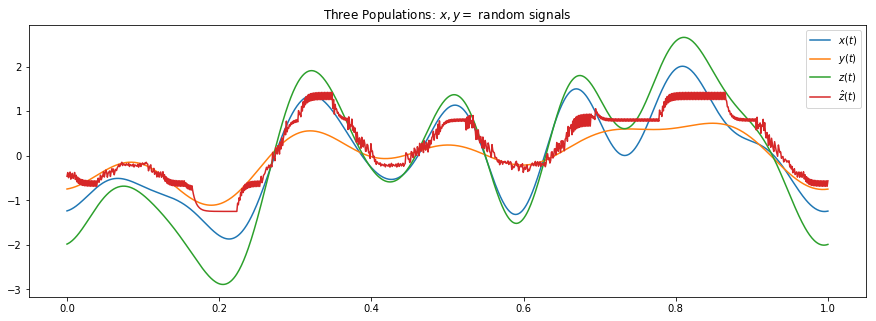

In [23]:
x5b, X5B= generate_signal(T=1, dt=0.001, rms=1, limit=8, seed=12)
y5b, Y5B = generate_signal(T=1, dt=0.001, rms=0.5, limit=5, seed=12)

A5bx = np.zeros([N,len(x5b)])
A5by = np.zeros([N,len(x5b)])
A5bz = np.zeros([N,len(x5b)])

for n in range(0,N):
    A5bx[n] = postSynapticFilter(Neurons5x[n], x5b)
xhat5b = np.dot(np.transpose(A5bx), d5x)

for n in range(0,N):
    A5by[n] = postSynapticFilter(Neurons5y[n], y5b)
yhat5b = np.dot(np.transpose(A5by), d5y)

z5b = xhat5b + yhat5b

for n in range(0,N):
    A5bz[n] = postSynapticFilter(Neurons5z[n], z5b)
zhat5b = np.dot(np.transpose(A5bz), d5z)

plt.figure(figsize(15,5))
plt.title("Three Populations: $x,y=$ random signals")
plt.plot(t5, x5b, label="$x(t)$")
plt.plot(t5, y5b, label="$y(t)$")
plt.plot(t5, x5b + y5b, label="$z(t)$")
plt.plot(t5, zhat5b, label="$\hat z(t)$")
plt.legend(loc="best")
plt.show();

## 6) Computing with vectors

Do the same thing as questions 4 and 5, but with 2-dimensional vectors instead of scalars.  Everything else is the same.  For your encoders $e$, randomly generate them over the unit circle.  

The function to compute is $w = x-3y+2z-2q$.  This requires five groups of neurons: $x$, $y$, $z$, $q$, and $w$.  Each of them represents a 2-dimensional value.  The outputs from $x$, $y$, $z$, and $q$ all feed into $w$.

In [24]:
class SingleNeuron2D():
    T = 0
    dt = 0.001
    x = np.linspace(0,1, int(1/dt))
    y = np.linspace(0,1, int(1/dt))
    time = np.linspace(0,1, int(1/dt))
    encoder = [0] * 2
    maxFR = 0
    xint = 0
    alpha = 0
    jbias = 0
    J = 0
    a = 0
    V = 0
    dV = 0
    tau_rc = 0
    tau_ref = 0
    spikes = 0
    
    def __init__(self, T, dt, tau_rc, tau_ref, encoder = None, seed = None, maxFR = None, xlim = None):
        if seed:
            np.random.seed(seed) 
    # initialize some variables
        if encoder:
            self.encoder = np.array(encoder)
        else:
            self.encoder = np.array([np.random.uniform(-1,1), np.random.uniform(-1,1)])
    # randomly set the firing rate and xint
        if maxFR:
            self.maxFR = maxFR
        else:
            self.maxFR = np.random.uniform(low = 100, high = 200)
        if not(xlim):
            xlim = 1
        self.xint = np.random.uniform(low = -2, high = 2)
        
        self.T = T
        self.dt = dt
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.x = np.linspace(-xlim, xlim, int(2*xlim/dt))
        self.y = np.linspace(-xlim, xlim, int(2*xlim/dt))
        self.time = np.linspace(0, T, int(T/dt))    
        
    # calculate jbias and alpha
        self.alpha = calcAlpha(self.tau_ref, self.tau_rc, self.maxFR, self.xint, xmax = 2)
        self.jbias = self.alpha * self.xint
        
        self.J = self.getJ([self.x, self.y])                        # Calculate the current as a funtion of input x
        self.a = LIFcurve(tau_ref, tau_rc, self.J)        # Calculate the firing rate as a function of current
        
    def getJ(self, x):
        alpx = np.dot(self.alpha,x)
        try:
            J = np.dot(self.encoder, alpx) + self.jbias
        except e:
            J = np.dot(self.encoder, np.transpose(alpx)) + self.jbias
        J[J < 0] = 0
        return J
        
    def spikeTrain(self, x):
        n = np.int(self.T/self.dt)          # number of samples
        if isinstance(x, int):
            j = np.full([n], self.getJ(x))  # if our input signal is constant
        else:
            j = self.getJ(x)                # if input is a function of time
        
    # initialize our Spikes, Voltage and dV functions
        self.V = np.zeros([n])
        self.spikes = np.zeros([n])
        self.V[0] = 0
        self.dV = np.zeros([n])
    # Calculate dV and V for each time step
        for i in range(0,n):
            self.dV[i] = 2*pi/self.tau_rc * (j[i] - self.V[i]) * self.dt     # calculate dV given the previous V
            if i < len(self.V)-1:                                            # if we're not at the end
                self.V[i+1] = self.V[i] + self.dV[i]                         # calculate next V given dV and previous V
                if self.V[i+1] >= 1:                                         # if the next V will be over 1, we spike and set V to 0
                    self.V[i+1] = 0
                    self.spikes[i] = 1 
        return self.spikes
    def plot(self):
        plt.plot(self.x, self.a)

In [25]:
def calcDecoders2D(A, x, dt, noise = None, sigmaCoeff = None, fn = None):
    if not(fn):
        def fn(a):
            return a
    Ypsilon = dt * np.dot(A, np.transpose(fn(x)))
    Gamma = dt * np.matmul(A, np.transpose(A))
    if noise:
        Var = np.power(sigmaCoeff * np.max(A),2) * np.identity(A.shape[0])
        Gamma += Var
    Gamma_inv = np.linalg.pinv(Gamma)
    try:
        d = np.dot(Gamma_inv, Ypsilon) 
#         d = np.transpose(np.matrix([d]))
    except e:
        d = np.dot(Gamma_inv, np.transpose(Ypsilon))
    return d # vector of decoders

<ol style="list-style:lower-alpha outside none;" start="1">
<li>[1 mark] Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for $x=[0.5,1], y=[0.1,0.3], z=[0.2,0.1], q = [0.4,-0.2]$.  (Note that these are all constants so they don't change over time, but still plot it for 1.0 seconds on one or more 2D graphs)</li>
</ol>

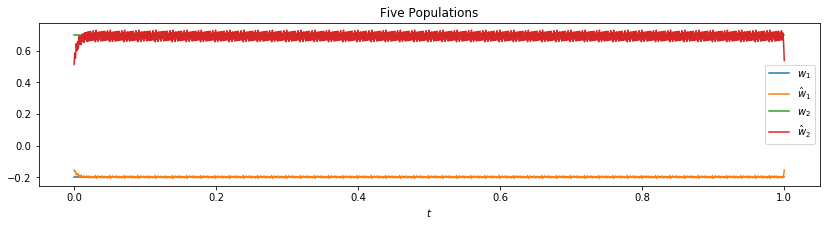

In [26]:
def W(x,y,z,q):
    return x - 3*y + 2*z - 2*q

def fx6(x):
    return x
def fy6(y):
    return -3*y
def fz6(z):
    return 2*z
def fq6(q):
    return -2*q

t6 = np.linspace(0,1, int(1/dt))
x6 = np.zeros([2, int(1/dt)])
y6 = np.zeros([2, int(1/dt)])
z6 = np.zeros([2, int(1/dt)])
q6 = np.zeros([2, int(1/dt)])
x6[0:] = 0.5
x6[1:] = 1
y6[0:] = 0.1
y6[1:] = 0.3
z6[0:] = 0.2
z6[1:] = 0.1
q6[0:] = 0.4
q6[1:]= -0.2
w6 = W(x6,y6,z6,q6)

A6x = np.zeros([N,len(t5)])
A6y = np.zeros([N,len(t5)])
A6z = np.zeros([N,len(t5)])
A6q = np.zeros([N,len(t5)])
A6w = np.zeros([N,len(t5)])
Neurons6x = [None] * N
Neurons6y = [None] * N
Neurons6z = [None] * N
Neurons6q = [None] * N
Neurons6w = [None] * N

for n in range(0,N):
    Neurons6x[n] = SingleNeuron2D(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = n)
    A6x[n] = postSynapticFilter(Neurons6x[n], x6)
    Neurons6y[n] = SingleNeuron2D(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = N+n)
    A6y[n] = postSynapticFilter(Neurons6y[n], y6)
    Neurons6z[n] = SingleNeuron2D(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = 2*N+n)
    A6z[n] = postSynapticFilter(Neurons6z[n], z6)
    Neurons6q[n] = SingleNeuron2D(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = 3*N+n)
    A6q[n] = postSynapticFilter(Neurons6q[n], q6)
    Neurons6w[n] = SingleNeuron2D(T, dt, tau_rc = 0.02, tau_ref = 0.002, seed = 4*N+n)
    
d6x = calcDecoders2D(A6x, x6, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = fx6)
xhat6 = np.transpose(np.dot(np.transpose(A6x), d6x))
d6y = calcDecoders2D(A6y, y6, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = fy6)
yhat6 = np.transpose(np.dot(np.transpose(A6y), d6y))
d6z = calcDecoders2D(A6z, z6, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = fz6)
zhat6 = np.transpose(np.dot(np.transpose(A6z), d6z))
d6q = calcDecoders2D(A6q, q6, dt = 0.001, noise = True, sigmaCoeff = 0.1, fn = fq6)
qhat6 = np.transpose(np.dot(np.transpose(A6q), d6q))
w6_ = xhat6 + yhat6 + zhat6 + qhat6

for n in range(0,N):
    A6w[n] = postSynapticFilter(Neurons6w[n], w6_)
d6w = calcDecoders2D(A6w, w6_, dt = 0.001, noise = True, sigmaCoeff = 0.1)
what6 = np.transpose(np.dot(np.transpose(A6w), d6w))

plt.figure(figsize(14,3))
plt.title("Five Populations")
# plt.title("1st Dimension")
# plt.plot(t6, x6[0], label="$x_1$")
# plt.plot(t6, y6[0], label="$y_1$")
# plt.plot(t6, z6[0], label="$z_1$")
# plt.plot(t6, q6[0], label="$q_1$")
plt.plot(t6, w6[0], label="$w_1$")
# plt.plot(t6, xhat6[0], label="$\hat x_1$")
# plt.plot(t6, yhat6[0], label="$\hat y_1$")
# plt.plot(t6, zhat6[0], label="$\hat z_1$")
# plt.plot(t6, qhat6[0], label="$\hat q_1$")
plt.plot(t6, what6[0], label="$\hat w_1$")
# plt.legend(loc="best")


# plt.figure(figsize(16,8))
# plt.title("2nd Dimension")
# plt.plot(t6, x6[1], label="$x_2$")
# plt.plot(t6, y6[1], label="$y_2$")
# plt.plot(t6, z6[1], label="$z_2$")
# plt.plot(t6, q6[1], label="$q_2$")
plt.plot(t6, w6[1], label="$w_2$")
# plt.plot(t6, xhat6[1], label="$\hat x_2$")
# plt.plot(t6, yhat6[1], label="$\hat y_2$")
# plt.plot(t6, zhat6[1], label="$\hat z_2$")
# plt.plot(t6, qhat6[1], label="$\hat q_2$")
plt.plot(t6, what6[1], label="$\hat w_2$")
plt.xlabel("$t$")
plt.legend(loc="best")
plt.show();

<ol style="list-style:lower-alpha outside none;" start="2">
<li>[0.5 marks] Produce the same plot for $x=[0.5,1], y=[sin(4\pi t),0.3], z=[0.2,0.1], q = [sin(4\pi t),-0.2]$.</li>
</ol>

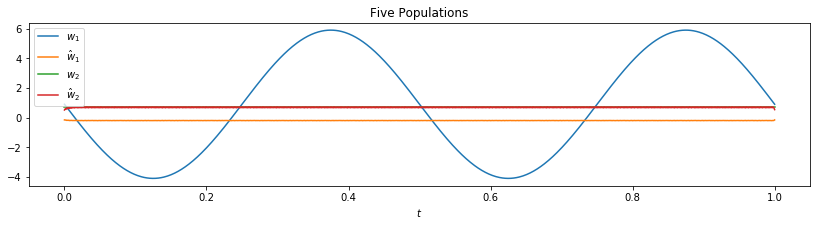

In [27]:
x6b = np.zeros([2, int(1/dt)])
y6b = np.zeros([2, int(1/dt)])
z6b = np.zeros([2, int(1/dt)])
q6b = np.zeros([2, int(1/dt)])
x6b[0:] = 0.5
x6b[1:] = 1
y6b[0:] = np.sin(4*pi*t6)
y6b[1:] = 0.3
z6b[0:] = 0.2
z6b[1:] = 0.1
q6b[0:] = np.sin(4*pi*t6)
q6b[1:]= -0.2
w6b = W(x6b,y6b,z6b,q6b)

A6bx = np.zeros([N,len(t5)])
A6by = np.zeros([N,len(t5)])
A6bz = np.zeros([N,len(t5)])
A6bq = np.zeros([N,len(t5)])
A6bw = np.zeros([N,len(t5)])

for n in range(0,N):
    A6bx[n] = postSynapticFilter(Neurons6x[n], x6b)
    A6by[n] = postSynapticFilter(Neurons6y[n], y6b)
    A6bz[n] = postSynapticFilter(Neurons6z[n], z6b)
    A6bq[n] = postSynapticFilter(Neurons6q[n], q6b)

xhat6b = np.transpose(np.dot(np.transpose(A6bx), d6x))
yhat6b = np.transpose(np.dot(np.transpose(A6by), d6y))
zhat6b = np.transpose(np.dot(np.transpose(A6bz), d6z))
qhat6b = np.transpose(np.dot(np.transpose(A6bq), d6q))
w6b_ = xhat6 + yhat6 + zhat6 + qhat6

for n in range(0,N):
    A6bw[n] = postSynapticFilter(Neurons6w[n], w6b_)
what6b = np.transpose(np.dot(np.transpose(A6bw), d6w))

plt.figure(figsize(14,3))
plt.title("Five Populations")
# plt.title("1st Dimension")
# plt.plot(t6, x6b[0], label="$x_1$")
# plt.plot(t6, y6b[0], label="$y_1$")
# plt.plot(t6, z6b[0], label="$z_1$")
# plt.plot(t6, q6b[0], label="$q_1$")
plt.plot(t6, w6b[0], label="$w_1$")
# plt.plot(t6, xhat6b[0], label="$\hat x_1$")
# plt.plot(t6, yhat6b[0], label="$\hat y_1$")
# plt.plot(t6, zhat6b[0], label="$\hat z_1$")
# plt.plot(t6, qhat6b[0], label="$\hat q_1$")
plt.plot(t6, what6b[0], label="$\hat w_1$")
# plt.legend(loc="best")


# plt.figure(figsize(16,8))
# plt.title("2nd Dimension")
# plt.plot(t6, x6b[1], label="$x_2$")
# plt.plot(t6, y6b[1], label="$y_2$")
# plt.plot(t6, z6b[1], label="$z_2$")
# plt.plot(t6, q6b[1], label="$q_2$")
plt.plot(t6, w6b[1], label="$w_2$")
# plt.plot(t6, xhat6b[1], label="$\hat x_2$")
# plt.plot(t6, yhat6b[1], label="$\hat y_2$")
# plt.plot(t6, zhat6b[1], label="$\hat z_2$")
# plt.plot(t6, qhat6b[1], label="$\hat q_2$")
plt.plot(t6, what6b[1], label="$\hat w_2$")
plt.xlabel("$t$")
plt.legend(loc="best")
plt.show();

<ol style="list-style:lower-alpha outside none;" start="3">
<li>[0.5 marks] Describe your results and discuss why and how they stray from the expected answer.</li></ol>

> These neurons have trouble tracking the high amplitude vertically shifted sine wave since the neurons do not respond well to the high magnitude, since the neurons in the populations saturate at +/- 1. Also, since the function $w(x,y,x,q)$  puts the two wave components out of phase, the neurons signals which track these waves are cancel eachother out.